In [20]:

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Date wrangling
from datetime import datetime, timedelta

# Data wrangling
import pandas as pd 

# The deep learning class
#from deep_model import DeepModelTS

# Reading the configuration file
import yaml

# Directory managment 
import os

In [1]:
# Loading pandas
import pandas as pd

# Loading date wrangling package
from datetime import datetime

# Reading the input data
d = pd.read_csv('energy_cons_dataset/DAYTON_hourly.csv')

# Formating to datetime
d['Datetime'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in d['Datetime']]

# Making sure there are no duplicated data
# If there are some duplicates we average the data during those duplicated days
d = d.groupby('Datetime', as_index=False)['DAYTON_MW'].mean()

# Sorting the values
d.sort_values('Datetime', inplace=True)

In [2]:
import numpy as np

In [3]:
# A method to create X and Y matrix from a time series list for the training of 
    deep learning models 

def create_X_Y(ts: list, lag: int) -> tuple:
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag):
            Y.append(ts[i + lag])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an LSTM input shape 
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, Y


In [4]:
# Deep learning packages
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Defining the number of neurons in the LSTM layer
n_layer = 50

# Defining how many lags will be used in the time series
n_lag = 3

# Defining the model
model = Sequential()
model.add(LSTM(n_layer, activation='relu', input_shape=(n_lag, 1)))
model.add(Dense(1))

# The objective functions which will be minimized is mean squared error (mse)
model.compile(optimizer='adam', loss='mse')

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorboard\comp

In [5]:
# Data wrangling
import pandas as pd
import numpy as np

# Deep learning: 
from keras.models import Sequential
from keras.layers import LSTM, Dense


class DeepModelTS():

    #a deep time series model

    def __init__(
        self, 
        data: pd.DataFrame, 
        Y_var: str,
        lag: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0
    ):

        self.data = data 
        self.Y_var = Y_var 
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split

    @staticmethod
    def create_X_Y(ts: list, lag: int) -> tuple:
        #create X and Y matrix from a time series list for the training of deep learning models 
    
        X, Y = [], []

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                X.append(ts[i:(i + lag)])

        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None
        ):
        
        #A method to create data for the neural network model
        
        # Extracting the main variable we want to forecast
        y = self.data[self.Y_var].tolist()

        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, self.lag)

        # Creating training and test sets 
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:
            index = round(len(X) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_test = X[-index:]     
            
            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]

        return X_train, X_test, Y_train, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_test, Y_train, Y_test = self.create_data_for_NN()

        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(self.lag, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False
        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_test, Y_test)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, X_test, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _ = self.create_data_for_NN(use_last_n=self.lag)        

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            yhat.append(fc)

            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, 0)

            # Reshaping for the next iteration
            X = np.reshape(X, (1, len(X), 1))

        return yhat    

In [7]:
# Initiating the class
deep_learner = DeepModelTS(
data = d,
Y_var = 'DAYTON_MW',
lag = 6,
LSTM_layer_depth = 50,
epochs = 10,
batch_size = 256,
train_test_split = 0.15
)

In [8]:
# Fitting the model
model = deep_learner.LSTModel()

Train on 103075 samples, validate on 18190 samples
Epoch 1/10
103075/103075 [==============================] - 14s 132us/step - loss: 164918.3305 - val_loss: 19147.1412
Epoch 2/10
103075/103075 [==============================] - 6s 60us/step - loss: 19743.8459 - val_loss: 16368.4349
Epoch 3/10
103075/103075 [==============================] - 7s 70us/step - loss: 18839.3475 - val_loss: 14154.4429
Epoch 4/10
103075/103075 [==============================] - 6s 60us/step - loss: 15477.8590 - val_loss: 11781.4531
Epoch 5/10
103075/103075 [==============================] - 6s 60us/step - loss: 22491.3182 - val_loss: 16402.8023
Epoch 6/10
103075/103075 [==============================] - 7s 63us/step - loss: 14223.0651 - val_loss: 10484.4214
Epoch 7/10
103075/103075 [==============================] - 7s 64us/step - loss: 11609.3610 - val_loss: 10606.4215
Epoch 8/10
103075/103075 [==============================] - 6s 63us/step - loss: 9339.5357 - val_loss: 8052.6284
Epoch 9/10
103075/103075 [==

In [9]:
deep_learner = DeepModelTS(
data = d,
Y_var = 'DAYTON_MW',
lag = 24, # 24 past hours are used
LSTM_layer_depth = 50,
epochs = 10,
batch_size = 256,
train_test_split = 0.15
)
model = deep_learner.LSTModel()

Train on 103060 samples, validate on 18187 samples
Epoch 1/10
103060/103060 [==============================] - 29s 286us/step - loss: 58992.4795 - val_loss: 67765.4425
Epoch 2/10
103060/103060 [==============================] - 28s 270us/step - loss: 63405.7528 - val_loss: 815910.5896
Epoch 3/10
103060/103060 [==============================] - 29s 280us/step - loss: 222443.7925 - val_loss: 100300.3309
Epoch 4/10
103060/103060 [==============================] - 28s 269us/step - loss: 81227.8729 - val_loss: 65851.7050
Epoch 5/10
103060/103060 [==============================] - 26s 248us/step - loss: 54107.0813 - val_loss: 50115.5673
Epoch 6/10
103060/103060 [==============================] - 27s 264us/step - loss: 41771.7553 - val_loss: 38557.9849
Epoch 7/10
103060/103060 [==============================] - 29s 282us/step - loss: 34457.3790 - val_loss: 35032.1297
Epoch 8/10
103060/103060 [==============================] - 31s 305us/step - loss: 40235.7970 - val_loss: 51220.4320
Epoch 9/10

In [10]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = d['DAYTON_MW'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)

In [12]:
import matplotlib.pyplot as plt

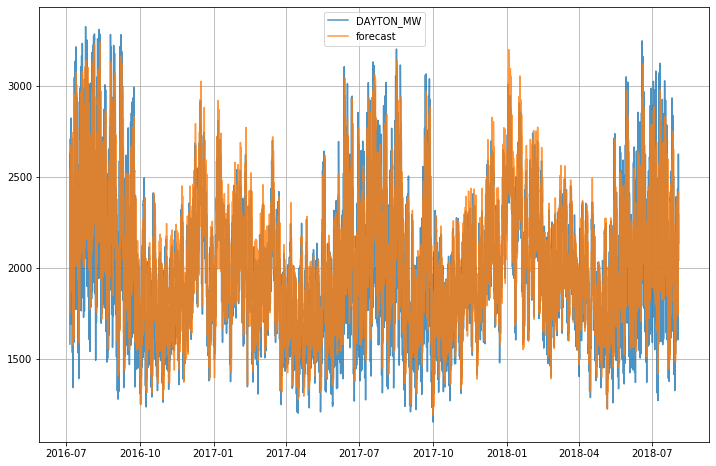

In [13]:
yhat = deep_learner.predict()
# Constructing the forecast dataframe
fc = d.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts

plt.figure(figsize=(12, 8))
for dtype in ['DAYTON_MW', 'forecast']:
  plt.plot(
    'Datetime',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()
plt.show()

In [17]:
# Creating the model using full data and forecasting n steps ahead
deep_learner = DeepModelTS(
data=d,
Y_var='DAYTON_MW',
lag=48,
LSTM_layer_depth=64,
epochs=10,
train_test_split=0
)

# Fitting the model
deep_learner.LSTModel()
# Forecasting n steps ahead
n_ahead = 168
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

Epoch 1/10
121223/121223 [==============================] - 77s 632us/step - loss: 253817174.0656
Epoch 2/10
121223/121223 [==============================] - 73s 601us/step - loss: 37680318.5615
Epoch 3/10
121223/121223 [==============================] - 79s 652us/step - loss: 56604419.0327
Epoch 4/10
121223/121223 [==============================] - 68s 559us/step - loss: 570820.1981
Epoch 5/10
121223/121223 [==============================] - 71s 588us/step - loss: 210426.8795
Epoch 6/10
121223/121223 [==============================] - 94s 774us/step - loss: 177099.4081
Epoch 7/10
121223/121223 [==============================] - 84s 696us/step - loss: 2179028.2478
Epoch 8/10
121223/121223 [==============================] - 79s 655us/step - loss: 202138.8261
Epoch 9/10
121223/121223 [==============================] - 69s 570us/step - loss: 166727.5590
Epoch 10/10
121223/121223 [==============================] - 68s 561us/step - loss: 160091.3983


In [21]:
# Constructing the forecast dataframe
fc = d.tail(400).copy() 
fc['type'] = 'original'

last_date = max(fc['Datetime'])
hat_frame = pd.DataFrame({
    'Datetime': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'DAYTON_MW': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)


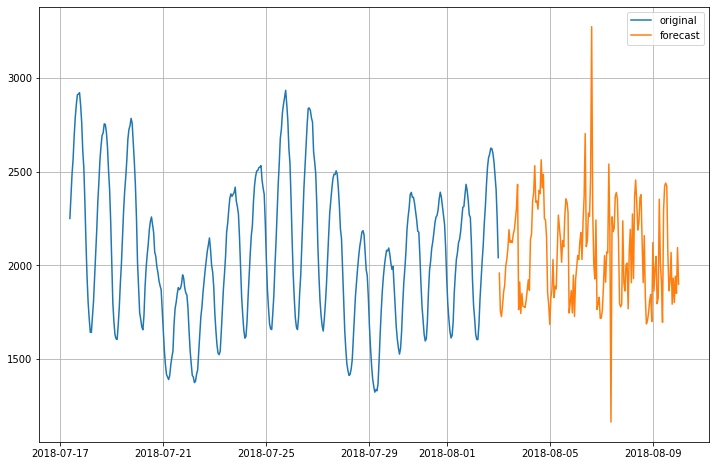

In [22]:


# Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'Datetime', 
        'DAYTON_MW', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()
plt.show()    